In [1]:
import h5py
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
from matplotlib import animation
import pde
import sklearn

from IPython.display import Video

In [11]:
print(sklearn.__version__)

1.0.2


In [8]:
print(ps.__version__)

1.6.3


In [2]:
## LOAD DATA ## 
w0=1
filename = f'./Data/Simulations/AO_w_{w0}.h5'
data = h5py.File(filename)

t = np.array(data['times'])
dt = t[1]-t[0]

x = np.array(data['x'])
dx = x[1]-x[0]

u = np.array(data['data'])
u_dot = ps.FiniteDifference(axis=0)._differentiate(u, t=dt)

data.close()



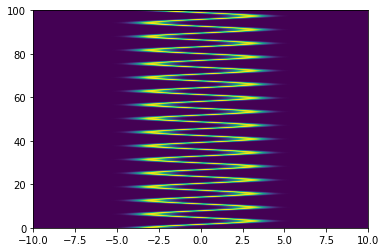

In [3]:
plt.pcolormesh(x,t, np.abs(u)**2)

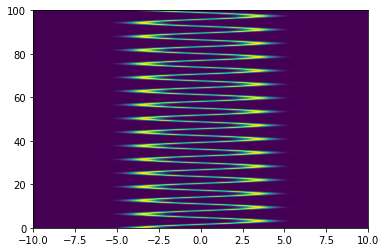

In [4]:
plt.pcolormesh(x, t, np.abs(u_dot)**2)

In [10]:
## GET REAL AND IMG PART TO USE WITH SINDY ## 

training_frac = 0.01
train_sample = int(len(t)*training_frac)

u_real = np.real(u)
u_img = np.imag(u)

u_dot_real = np.real(u_dot)
u_dot_img = np.imag(u_dot)

u_shaped = np.zeros(shape=(len(x), train_sample, 3))
u_shaped[:,:, 0]=u_real[:train_sample].T
u_shaped[:,:, 1]=u_img[:train_sample].T
u_shaped[:,:, 2]=np.tile(x,(train_sample,1)).T # add x values to pass to u and u_dot (in these way one can introduce spatial potential terms)

u_dot_shaped = np.zeros(shape=(len(x), train_sample, 2))
u_dot_shaped[:,:, 0]=u_dot_real[:train_sample].T
u_dot_shaped[:,:, 1]=u_dot_img[:train_sample].T

u_shaped.shape

(1000, 100, 3)

In [11]:
## DEFINE CANDIDATES LIBRARY ## 

# 2nd order poly library
poly_library = ps.PolynomialLibrary(include_bias=False, degree=2) 

# PDE library
library_functions = [lambda x: x]
library_function_names = [lambda x: x]
pde_library = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=2, spatial_grid=x, 
                        include_bias=True, is_uniform=True, include_interaction=False)

# Tensor polynomial library with the PDE library
tensor_array = [[1, 1]]
inputs_temp = np.tile([0, 1, 2], 2)
inputs_per_library = np.reshape(inputs_temp, (2, 3))
inputs_per_library[1,2] = 0 # only compute PDs for psi_real and psi_img
inputs_per_library[0] = [2, 2, 2] # only compute polynomial for x input feature


generalized_library = ps.GeneralizedLibrary(
    [poly_library, pde_library],
    tensor_array=tensor_array,
    inputs_per_library=inputs_per_library,
)

## DEFINE OPTIMIZER AND FIT MODEL ## 

optimizer = ps.STLSQ(threshold=0.1, verbose=True)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, feature_names=['psi_r', 'psi_i', 'x'])
model.fit(u_shaped, x_dot=u_dot_shaped, t=dt)
model.print()

print(generalized_library.get_feature_names(), "\n")


 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 2.3849e+00 ... 4.9771e-02 ...          4 ... 2.4347e+00
         1 ... 5.2987e-02 ... 4.9923e-02 ...          4 ... 1.0291e-01
(psi_r)' = -0.500 psi_i_11 + 0.500 x^2 psi_i
(psi_i)' = 0.500 psi_r_11 + -0.500 x^2 psi_r
['x2', 'x2^2', '1', 'x0', 'x1', 'x0_1', 'x1_1', 'x0_11', 'x1_11', 'x2 1', 'x2 x0', 'x2 x1', 'x2 x0_1', 'x2 x1_1', 'x2 x0_11', 'x2 x1_11', 'x2^2 1', 'x2^2 x0', 'x2^2 x1', 'x2^2 x0_1', 'x2^2 x1_1', 'x2^2 x0_11', 'x2^2 x1_11'] 



In [12]:
psi_r_rhs=model.equations(precision=16)[0].replace('psi_i_11', 'laplace(psi_i)').replace(' ', '*').replace('*+*', '+').replace('^','**')
psi_i_rhs=model.equations(precision=16)[1].replace('psi_r_11', 'laplace(psi_r)').replace(' ', '*').replace('*+*', '+').replace('^','**')

## for complex equation other way is
# def multipleReplace(text, wordDict):
#     for key in wordDict:
#         text = text.replace(key, wordDict[key])
#     return text

In [13]:
psi_r_rhs

'-0.4996657255184589*laplace(psi_i)+0.4995612224380712*x**2*psi_i'

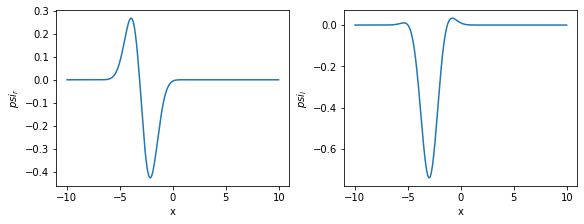

In [ ]:
## FITTED MODEL SIMULATION ## 

# TO DO: GENERALIZE EQUATION WRITING FROM MODEL RESULT

# uxx_re = model.coefficients()[0,8]
# uxx_im = model.coefficients()[1,7]
# x2psi_re = model.coefficients()[0,18]
# x2psi_im = model.coefficients()[1,17]

# eq = pde.PDE({'psi_r':'{}*laplace(psi_i)+{}*x*x*psi_i'.format(uxx_re, x2psi_re), 
#               'psi_i':'{}*laplace(psi_r)+{}*x*x*psi_r'.format(uxx_im, x2psi_im)})

eq=pde.PDE({'psi_r':psi_r_rhs, 
           'psi_i':psi_i_rhs})


## DEFINE SPATIAL GRID ##

Nx = len(x) # number of spatial points
x_left = x[0]
x_right = x[-1]

grid = pde.CartesianGrid([(x_left,x_right)], Nx, periodic=False)
grid.coordinate_arrays = (x,) # this is needed otherwise endpoints are excluded

## DEFINE INITIAL STATE FOR SIMULATION (use last u entry) ##

initial_state_r = pde.ScalarField(grid, u_real[train_sample], label= '$psi_r$')
initial_state_i = pde.ScalarField(grid, u_img[train_sample], label = '$psi_i$')

initial_state = pde.FieldCollection([initial_state_r, initial_state_i])

initial_state.plot()


In [ ]:
## PERFORM SIMULATION ##

# define storage 
storage = pde.MemoryStorage() # for movie

# simulation time and step (1e-6 and 1e-5 seems to work, more testing needed to se if less can be used)
t_range = t[-1]-t[train_sample]
dt_sim = 1e-5

# points to use in animation 
N_t_anim = len(t)-train_sample-1 # this is enough do not change it 
dt_anim = t_range/N_t_anim


solver = pde.ExplicitSolver(eq, scheme="runge-kutta", adaptive=False)
controller = pde.Controller(solver, t_range=t_range, tracker=['progress', storage.tracker(interval=dt_anim)])
_ = controller.run(initial_state, dt=dt_sim)

100%|██████████| 3.999999999999913/3.999999999999913 [01:01<00:00, 15.39s/it]


In [ ]:
## COMBINE REAL AND IMAGINARY PART ## 

data_sim = np.array([storage.data[i][0]+1j*storage.data[i][1] for i in range(len(storage))])
storage_sim = pde.MemoryStorage(times=t[train_sample]+np.array(storage.times), data=data_sim, field_obj=pde.ScalarField(grid, label='$psi_sim$', dtype=np.complex128))


In [ ]:
storage_sim.grid.cell_coords.flatten()

array([-9.99, -9.97, -9.95, -9.93, -9.91, -9.89, -9.87, -9.85, -9.83,
       -9.81, -9.79, -9.77, -9.75, -9.73, -9.71, -9.69, -9.67, -9.65,
       -9.63, -9.61, -9.59, -9.57, -9.55, -9.53, -9.51, -9.49, -9.47,
       -9.45, -9.43, -9.41, -9.39, -9.37, -9.35, -9.33, -9.31, -9.29,
       -9.27, -9.25, -9.23, -9.21, -9.19, -9.17, -9.15, -9.13, -9.11,
       -9.09, -9.07, -9.05, -9.03, -9.01, -8.99, -8.97, -8.95, -8.93,
       -8.91, -8.89, -8.87, -8.85, -8.83, -8.81, -8.79, -8.77, -8.75,
       -8.73, -8.71, -8.69, -8.67, -8.65, -8.63, -8.61, -8.59, -8.57,
       -8.55, -8.53, -8.51, -8.49, -8.47, -8.45, -8.43, -8.41, -8.39,
       -8.37, -8.35, -8.33, -8.31, -8.29, -8.27, -8.25, -8.23, -8.21,
       -8.19, -8.17, -8.15, -8.13, -8.11, -8.09, -8.07, -8.05, -8.03,
       -8.01, -7.99, -7.97, -7.95, -7.93, -7.91, -7.89, -7.87, -7.85,
       -7.83, -7.81, -7.79, -7.77, -7.75, -7.73, -7.71, -7.69, -7.67,
       -7.65, -7.63, -7.61, -7.59, -7.57, -7.55, -7.53, -7.51, -7.49,
       -7.47, -7.45,

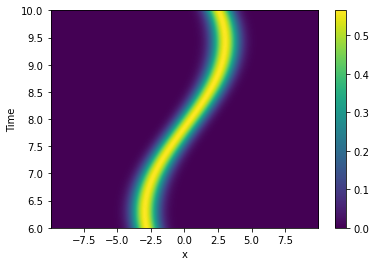

In [ ]:
## PLOT SIMULATION ##

pde.plot_kymograph(storage_sim, scalar='norm_squared')

In [ ]:
## GENERATE MOVIE ##

# set backend to nbagg for better movie quality, not working on deepnote
%matplotlib nbagg

sindy_sim = storage_sim.data
times = storage_sim.times

fig,ax = plt.subplots()

ax.set_xlabel('x')
ax.set_ylabel(r"$|\psi|^2$")
title = ax.set_title('', y=1.05)
line1, = ax.plot(x, np.abs(sindy_sim[0])**2, "k--", label="SINDy")
line2, = ax.plot(x, np.abs(u[train_sample])**2, "b", label="original")
plt.legend(loc=1, fontsize=8, fancybox=False)


def init():
    return line1, line2


def animate(i):
    ax.set_facecolor('white')
    line1.set_data(x, np.abs(sindy_sim[i])**2)
    line2.set_data(x, np.abs(u[i+train_sample])**2)
    title.set_text('Time = {0:1.3f}'.format(times[i]))
    return line1, line2


anim = animation.FuncAnimation(fig, animate, init_func=init, interval=1, blit=True,frames=np.arange(len(times)))

writer = animation.FFMpegWriter(fps=30, bitrate=-1)


print("Generating animation ...")
anim.save(f'./Data/Simulation_video/sindy_AO_w_{w0}.mov', writer=writer, dpi=150)
print("Done")

# reset backend to inline
%matplotlib inline


<IPython.core.display.Javascript object>

Generating animation ...
Done


In [ ]:
## VISUALIZE MOVIE ##

Video(f'./Data/Simulation_video/sindy_AO_w_{w0}.mov')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=964d390d-0269-41ab-86ee-4ee3752d1778' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>